In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

/Users/karthickkumarasamy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:

# Load your data
df = pd.read_csv("synthetic_5g_qos_dataset_10000.csv")

In [3]:


# Label encoding
le_src_ip = LabelEncoder()
le_dst_ip = LabelEncoder()
le_proto = LabelEncoder()
le_qos = LabelEncoder()

df['source_ip_enc'] = le_src_ip.fit_transform(df['source_ip'])
df['destination_ip_enc'] = le_dst_ip.fit_transform(df['destination_ip'])
df['protocol_enc'] = le_proto.fit_transform(df['protocol'])
df['qos_class_enc'] = le_qos.fit_transform(df['qos_class'])


In [4]:

# Features for embedding
source_ip_idx = df['source_ip_enc'].values
dest_ip_idx = df['destination_ip_enc'].values



In [5]:
source_ip_idx

array([3555, 8692, 2388, ..., 7641, 4254, 2746])

In [6]:

# Remaining numerical features
numerical_features = ['protocol_enc', 'packet_size', 'inter_arrival_time_ms', 'jitter_ms']
X_numerical = df[numerical_features].values

# One-hot encode output
y_cat = to_categorical(df['qos_class_enc'])

# Scale numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Split
X_train_num, X_test_num, src_train, src_test, dst_train, dst_test, y_train, y_test = train_test_split(
    X_numerical_scaled, source_ip_idx, dest_ip_idx, y_cat, test_size=0.2, random_state=42)

# Build a Model with IP Embeddings in Keras

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout

# Embedding dimensions
embedding_dim = 8
num_src_ips = len(le_src_ip.classes_)
num_dst_ips = len(le_dst_ip.classes_)

# Inputs
src_input = Input(shape=(1,), name='src_ip_input')
dst_input = Input(shape=(1,), name='dst_ip_input')
num_input = Input(shape=(X_train_num.shape[1],), name='numerical_input')

# Embedding layers
src_embed = Embedding(input_dim=num_src_ips, output_dim=embedding_dim)(src_input)
dst_embed = Embedding(input_dim=num_dst_ips, output_dim=embedding_dim)(dst_input)

# Flatten embeddings
src_flat = Flatten()(src_embed)
dst_flat = Flatten()(dst_embed)

# Concatenate all features
merged = Concatenate()([src_flat, dst_flat, num_input])

# Dense layers
x = Dense(64, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(y_train.shape[1], activation='softmax')(x)

# Model
model = Model(inputs=[src_input, dst_input, num_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ src_ip_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dst_ip_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 8)      │     74,400 │ src_ip_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 8)      │      2,032 │ dst_ip_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,344 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │         99 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    {'src_ip_input': src_train, 'dst_ip_input': dst_train, 'numerical_input': X_train_num},
    y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - accuracy: 0.7893 - loss: 0.6168 - val_accuracy: 0.9675 - val_loss: 0.1098
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.9605 - loss: 0.1315 - val_accuracy: 0.9794 - val_loss: 0.0689
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.9776 - loss: 0.0715 - val_accuracy: 0.9831 - val_loss: 0.0582
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.9861 - loss: 0.0497 - val_accuracy: 0.9844 - val_loss: 0.0558
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.9928 - loss: 0.0269 - val_accuracy: 0.9837 - val_loss: 0.0582
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.9968 - loss: 0.0132 - val_accuracy: 0.9819 - val_loss: 0.0623
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.9991 - loss: 0.0059 - val_accuracy: 0.9794 - val_loss: 0.0669
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.9995 - loss: 0.0041 - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
              precision    recall  f1-score   support

       URLLC       0.97      0.93      0.95       693
        eMBB       0.95      0.97      0.96       662
        mMTC       0.97      0.99      0.98       645

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



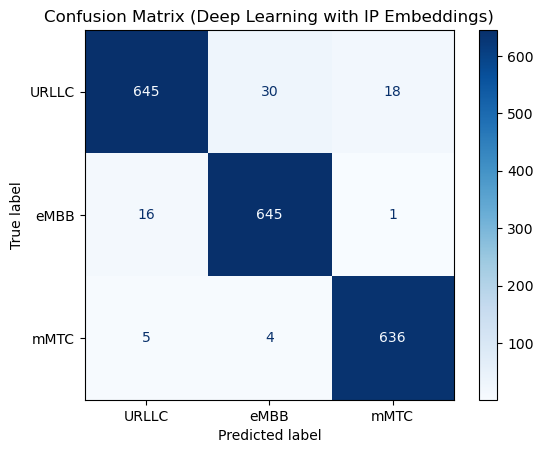

In [9]:
# Predict
y_pred_probs = model.predict({'src_ip_input': src_test, 'dst_ip_input': dst_test, 'numerical_input': X_test_num})
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Report
print(classification_report(y_true, y_pred, target_names=le_qos.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_qos.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Deep Learning with IP Embeddings)")
plt.show()



📄 Macro Average AUC: 0.9973
📄 Weighted Average AUC: 0.9972


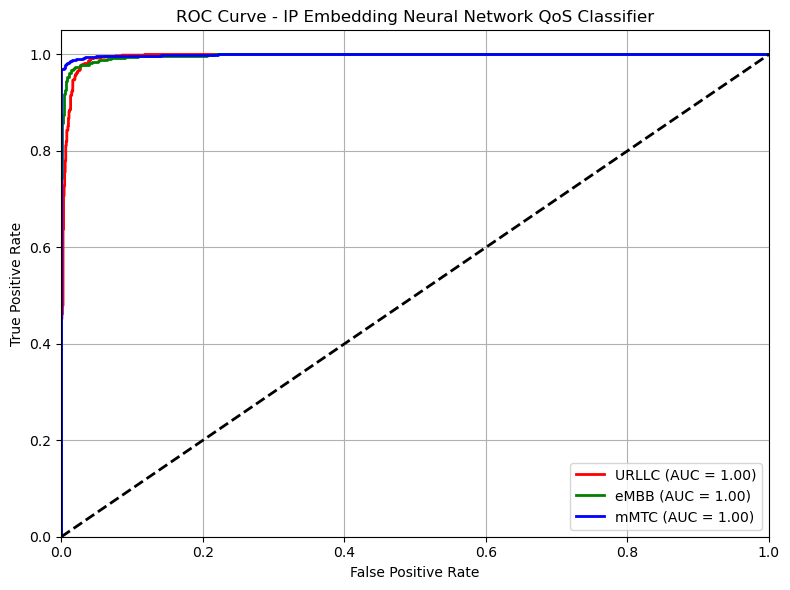

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Binarize true labels (already done as y_test)
n_classes = y_test.shape[1]  # Already one-hot encoded
# y_test is already in binarized format

# Step 2: y_pred_probs already computed from model.predict()

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
auc_scores = []

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    auc_scores.append(roc_auc[i])

# Step 4: Macro and weighted average AUC
macro_auc = np.mean(auc_scores)
weighted_auc = roc_auc_score(y_test, y_pred_probs, average='weighted', multi_class='ovr')

print(f"\n📄 Macro Average AUC: {macro_auc:.4f}")
print(f"📄 Weighted Average AUC: {weighted_auc:.4f}")

# Step 5: Plot ROC curves
colors = cycle(['red', 'green', 'blue'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{le_qos.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - IP Embedding Neural Network QoS Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
